# Single neuron dynamics

In [1]:
# fileName

fileName = 'eg_single-neuron' 

In [2]:
# libs

try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import pandas as pd
import seaborn as sns
import time

INFO       Cache size for target 'cython': 1175478576 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/bbpnrsoa/.cython/brian_extensions' directory. [brian2]


In [3]:
# simulation settings

sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 100 #ms

In [4]:
# defining the network

MODEL=sim.IF_cond_exp

PARS={'v_rest': -65.0, 
      'v_thresh': -37.0, 
      'v_reset': -65.0,
      'cm': 1.0, 
      'tau_m': 20.0, 
      'tau_refrac': 0.1, 
      'tau_syn_E': 5.0, 
      'tau_syn_I': 5.0, 
      'e_rev_E': 0.0, 
      'e_rev_I': -70.0, 
      'i_offset': 0.0}

cell0 = sim.Population(1, 
                      MODEL, 
                      cellparams=PARS,
                      label='cell0')

cell0.record(['v', 'gsyn_exc', 'gsyn_inh', 'spikes'])


In [5]:
# define the input

# not implemented in sPyNNaker
pulse = sim.ACSource(start=10, #ms
                     stop=80, #ms
                     amplitude=10, #nA
                     frequency=100,  #Hz
                     )

pulse.inject_into(cell0)
pulse.record()



In [9]:
# simulation run

tic = time.time()
sim.run(simtime)
toc = time.time() - tic
print(f'simulation time: {toc} [s]')

simulation time: 0.04332566261291504 [s]


cell0 spikes: {0: 1}


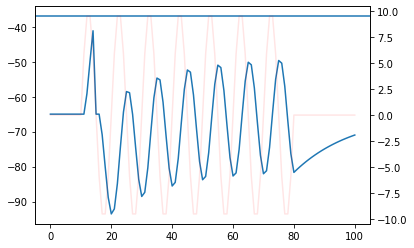

In [7]:
# results

v0=cell0.get_data(variables=['v']).segments[0].analogsignals[0]
ge0=cell0.get_data(variables=['gsyn_exc']).segments[0].analogsignals[0]
gi0=cell0.get_data(variables=['gsyn_inh']).segments[0].analogsignals[0]
spikes0=cell0.get_data(variables=['spikes']).segments[0].spiketrains[0]
i=pulse.get_data()

print(f'cell0 spikes: {cell0.get_spike_counts()}')
plt.plot(v0)
plt.axhline(y=cell0[0].v_thresh)
ax=plt.twinx()
ax.plot(i, 'r', alpha=0.1)